In [6]:
#pip install opencv-python
#!pip install scikit-learn

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.4 kB ? eta -:--:--
     -------------------------------- ----- 51.2/60.4 kB 375.8 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 401.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.2 MB 1.5 MB/s eta 0:00:06
   - -------------------------------------- 0.2/9.2 MB 2.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/9.2 MB 3.4 MB/s eta 0:00:03
   --- ------------------------------------ 0.9/9.2 MB 3.9 MB/s eta 0:00:03
   ---- ----------------------------------- 1.0/9.2 MB 4.1 MB/s eta 0:00:02
   ----- --------------------

In [81]:
#Librerias básicas
#================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob

# Configuración para machine learning
# ================================================================================
import tensorflow as tf
import tensorflow.keras as keras
from pandas.core.frame import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import multiprocessing

import cv2

# Activar SQL en Python
# ================================================================================
con = duckdb.connect(database=':memory:')

In [82]:
#Url Ari 
url_lcc    = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url_lc_img = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Curvas_de_luz_img/"
url        = "C:/Users/ASUS/OneDrive/Documentos/2023-2/Inteligencia/Proyecto/Exoplanet-detection-with-Neural-Network/"

In [3]:
#Urls Pater
url_lcc    = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/Curvas_de_luz_cor/"
url_lc_img = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/ClassificationExoplanets/Curvas_de_luz_img/" 
url        = "/home/pater/Desktop/CosasPater/UNAL/2023-02NovenoSemestre/Exoplanet-detection-with-Neural-Network/"

## Creación de las imagenes

In [83]:
Carac_Stars = pd.read_csv(url+"Carac_Stars.csv")
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [57]:
arch = os.listdir(url_lcc) 
arch.sort()
Stars_list = [star[3:-4] for star in arch]

s_flux  = []
s_err   = []
Id_real = []
for Str in arch:
    serie = pd.read_csv(url_lcc+Str).set_index('time')
    s_flux.append(np.array(serie['flux']))
    s_err.append(np.array(serie['flux_err']))
    Id_real.append(Str[3:-4])


In [58]:
Stars = pd.DataFrame()
Stars["ID"] = Id_real
Stars

,ID
0,10000162
1,10000941
2,10001368
3,10002049
4,10002266
...,...
7677,9993683
7678,9994381
7679,9995402
7680,9995771


In [59]:
Clas_Stars = con.execute("""select S.ID, case when C.Clasificacion == 'CANDIDATE' then 1 
                                              else 0             
                                         end as ClasBin
                            from Carac_Stars C inner join Stars S on (S.ID = C.Kepler_ID)
                            order by S.ID""").df()
Clas_Stars

,ID,ClasBin
0,10000162,1
1,10000941,1
2,10001368,1
3,10002049,1
4,10002266,0
...,...,...
7677,9993683,1
7678,9994381,1
7679,9995402,1
7680,9995771,1


In [84]:
#Obtención de las imagenes ya existentes en la carpeta
contenido = os.listdir(url_lc_img)
L_Str = []
for Str in contenido:
    Str = Str[4:-4]
    L_Str.append(Str)

In [21]:
#Se descargan las curvas de luz no existentes
KEPID = list(Stars['ID'])
i = 0
for name in KEPID:
    if name in L_Str:
        i += 1
        continue
    else:
        j = KEPID.index(name)
        name = int(name)
        plt.figure(figsize=(16,4))
        plt.plot(s_flux[j],color="#000000")
        plt.axis('off')
        plt.savefig(f"{url_lc_img}Img_{name}")
        continue

## División conjuntos train, validation, test

In [108]:
contenido = os.listdir(url_lc_img)
Img_LC = []
Img_LC_R = []
i = 0
fila_min = []
fila_max = []
for img in contenido:
    i += 1
    Img = cv2.imread(url_lc_img+img,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255
    Img_LC.append(Img)
    fila, colum = np.where(Img==0)
    fila_min.append(fila.min())
    fila_max.append(fila.max())
    if colum.max()-colum.min()+1==1128:
        Img = Img[:,colum.min():(colum.max()+3)]
    if colum.max()-colum.min()+1==1129:
        Img = Img[:,colum.min():(colum.max()+2)]
    else:
        Img = Img[:,colum.min():(colum.max()+1)]
    Img_LC_R.append(Img)

In [102]:
print(min(fila_min),max(fila_max))

61 342


In [109]:
for i in range(len(Img_LC_R)):
    Img = Img_LC_R[i][min(fila_min):(max(fila_max)+1),:]
    Img_LC_R[i] = Img
    if Img.shape[1]!=1129:
        print(i,Img.shape)

0 (282, 874)
1 (282, 874)
2 (282, 874)
3 (282, 874)
4 (282, 874)
5 (282, 874)
6 (282, 874)
7 (282, 874)
8 (282, 874)
9 (282, 874)
10 (282, 874)
11 (282, 874)
12 (282, 874)
13 (282, 874)
14 (282, 874)
15 (282, 874)
16 (282, 874)
17 (282, 874)
18 (282, 874)
19 (282, 874)
20 (282, 874)
21 (282, 874)
22 (282, 874)
23 (282, 874)
24 (282, 874)
25 (282, 874)
26 (282, 874)
27 (282, 874)
28 (282, 874)
29 (282, 874)
30 (282, 874)
31 (282, 874)
32 (282, 874)
33 (282, 874)
34 (282, 874)
35 (282, 874)
36 (282, 874)
37 (282, 874)
38 (282, 874)
39 (282, 874)
40 (282, 874)
41 (282, 874)
42 (282, 874)
43 (282, 874)
44 (282, 874)
45 (282, 874)
46 (282, 874)
47 (282, 874)
48 (282, 874)
49 (282, 874)
50 (282, 874)
51 (282, 874)
52 (282, 874)
53 (282, 874)
54 (282, 874)
55 (282, 874)
56 (282, 874)
57 (282, 874)
58 (282, 874)
59 (282, 874)
60 (282, 874)
61 (282, 874)
62 (282, 874)
63 (282, 874)
64 (282, 874)
65 (282, 874)
66 (282, 874)
67 (282, 874)
68 (282, 874)
69 (282, 874)
70 (282, 874)
71 (282, 874)
72

703 (282, 874)
704 (282, 874)
705 (282, 874)
706 (282, 874)
707 (282, 874)
708 (282, 874)
709 (282, 874)
710 (282, 874)
711 (282, 874)
712 (282, 874)
713 (282, 874)
714 (282, 874)
715 (282, 874)
716 (282, 874)
717 (282, 874)
718 (282, 874)
719 (282, 874)
720 (282, 874)
721 (282, 874)
722 (282, 874)
723 (282, 874)
724 (282, 874)
725 (282, 874)
726 (282, 874)
727 (282, 874)
728 (282, 874)
729 (282, 874)
730 (282, 874)
731 (282, 874)
732 (282, 874)
733 (282, 874)
734 (282, 874)
735 (282, 874)
736 (282, 874)
737 (282, 874)
738 (282, 874)
739 (282, 874)
740 (282, 874)
741 (282, 874)
742 (282, 874)
743 (282, 874)
744 (282, 874)
745 (282, 874)
746 (282, 874)
747 (282, 874)
748 (282, 874)
749 (282, 874)
750 (282, 874)
751 (282, 874)
752 (282, 874)
753 (282, 874)
754 (282, 874)
755 (282, 874)
756 (282, 874)
757 (282, 874)
758 (282, 874)
759 (282, 874)
760 (282, 874)
761 (282, 874)
762 (282, 874)
763 (282, 874)
764 (282, 874)
765 (282, 874)
766 (282, 874)
767 (282, 874)
768 (282, 874)
769 (282, 

1256 (282, 874)
1257 (282, 874)
1258 (282, 874)
1259 (282, 874)
1260 (282, 874)
1261 (282, 874)
1262 (282, 874)
1263 (282, 874)
1264 (282, 874)
1265 (282, 874)
1266 (282, 874)
1267 (282, 874)
1268 (282, 874)
1269 (282, 874)
1270 (282, 874)
1271 (282, 874)
1272 (282, 874)
1273 (282, 874)
1274 (282, 874)
1275 (282, 874)
1276 (282, 874)
1277 (282, 874)
1278 (282, 874)
1279 (282, 874)
1280 (282, 874)
1281 (282, 874)
1282 (282, 874)
1283 (282, 874)
1284 (282, 874)
1285 (282, 874)
1286 (282, 874)
1287 (282, 874)
1288 (282, 874)
1289 (282, 874)
1290 (282, 874)
1291 (282, 874)
1292 (282, 874)
1293 (282, 874)
1294 (282, 874)
1295 (282, 874)
1296 (282, 874)
1297 (282, 874)
1298 (282, 874)
1299 (282, 874)
1300 (282, 874)
1301 (282, 874)
1302 (282, 874)
1303 (282, 874)
1304 (282, 874)
1305 (282, 874)
1306 (282, 874)
1307 (282, 874)
1308 (282, 874)
1309 (282, 874)
1310 (282, 874)
1311 (282, 874)
1312 (282, 874)
1313 (282, 874)
1314 (282, 874)
1315 (282, 874)
1316 (282, 874)
1317 (282, 874)
1318 (28

2033 (282, 874)
2034 (282, 874)
2035 (282, 874)
2036 (282, 874)
2037 (282, 874)
2038 (282, 874)
2039 (282, 874)
2040 (282, 874)
2041 (282, 874)
2042 (282, 874)
2043 (282, 874)
2044 (282, 874)
2045 (282, 874)
2046 (282, 874)
2047 (282, 874)
2048 (282, 874)
2049 (282, 874)
2050 (282, 874)
2051 (282, 874)
2052 (282, 874)
2053 (282, 874)
2054 (282, 874)
2055 (282, 874)
2056 (282, 874)
2057 (282, 874)
2058 (282, 874)
2059 (282, 874)
2060 (282, 874)
2061 (282, 874)
2062 (282, 874)
2063 (282, 874)
2064 (282, 874)
2065 (282, 874)
2066 (282, 874)
2067 (282, 874)
2068 (282, 874)
2069 (282, 874)
2070 (282, 874)
2071 (282, 874)
2072 (282, 874)
2073 (282, 874)
2074 (282, 874)
2075 (282, 874)
2076 (282, 874)
2077 (282, 874)
2078 (282, 874)
2079 (282, 874)
2080 (282, 874)
2081 (282, 874)
2082 (282, 874)
2083 (282, 874)
2084 (282, 874)
2085 (282, 874)
2086 (282, 874)
2087 (282, 874)
2088 (282, 874)
2089 (282, 874)
2090 (282, 874)
2091 (282, 874)
2092 (282, 874)
2093 (282, 874)
2094 (282, 874)
2095 (28

2908 (282, 874)
2909 (282, 874)
2910 (282, 874)
2911 (282, 874)
2912 (282, 874)
2913 (282, 874)
2914 (282, 874)
2915 (282, 874)
2916 (282, 874)
2917 (282, 874)
2918 (282, 874)
2919 (282, 874)
2920 (282, 874)
2921 (282, 874)
2922 (282, 874)
2923 (282, 874)
2924 (282, 874)
2925 (282, 874)
2926 (282, 874)
2927 (282, 874)
2928 (282, 874)
2929 (282, 874)
2930 (282, 874)
2931 (282, 874)
2932 (282, 874)
2933 (282, 874)
2934 (282, 874)
2935 (282, 874)
2936 (282, 874)
2937 (282, 874)
2938 (282, 874)
2939 (282, 874)
2940 (282, 874)
2941 (282, 874)
2942 (282, 874)
2943 (282, 874)
2944 (282, 874)
2945 (282, 874)
2946 (282, 874)
2947 (282, 874)
2948 (282, 874)
2949 (282, 874)
2950 (282, 874)
2951 (282, 874)
2952 (282, 874)
2953 (282, 874)
2954 (282, 874)
2955 (282, 874)
2956 (282, 874)
2957 (282, 874)
2958 (282, 874)
2959 (282, 874)
2960 (282, 874)
2961 (282, 874)
2962 (282, 874)
2963 (282, 874)
2964 (282, 874)
2965 (282, 874)
2966 (282, 874)
2967 (282, 874)
2968 (282, 874)
2969 (282, 874)
2970 (28

3706 (282, 874)
3707 (282, 874)
3708 (282, 874)
3709 (282, 874)
3710 (282, 874)
3711 (282, 874)
3712 (282, 874)
3713 (282, 874)
3714 (282, 874)
3715 (282, 874)
3716 (282, 874)
3717 (282, 874)
3718 (282, 1130)
3719 (282, 1130)
3720 (282, 874)
3721 (282, 874)
3722 (282, 874)
3723 (282, 874)
3724 (282, 874)
3725 (282, 874)
3726 (282, 874)
3727 (282, 874)
3728 (282, 874)
3729 (282, 874)
3730 (282, 874)
3731 (282, 874)
3732 (282, 874)
3733 (282, 874)
3734 (282, 874)
3735 (282, 874)
3736 (282, 874)
3737 (282, 874)
3738 (282, 874)
3739 (282, 874)
3740 (282, 874)
3741 (282, 874)
3742 (282, 874)
3743 (282, 874)
3744 (282, 874)
3745 (282, 874)
3746 (282, 874)
3747 (282, 874)
3748 (282, 874)
3749 (282, 874)
3750 (282, 874)
3751 (282, 874)
3752 (282, 874)
3753 (282, 874)
3754 (282, 874)
3755 (282, 874)
3756 (282, 874)
3757 (282, 874)
3758 (282, 874)
3759 (282, 874)
3760 (282, 874)
3761 (282, 874)
3762 (282, 874)
3763 (282, 874)
3764 (282, 874)
3765 (282, 874)
3766 (282, 874)
3767 (282, 874)
3768 (

4555 (282, 874)
4556 (282, 874)
4557 (282, 874)
4558 (282, 874)
4559 (282, 874)
4560 (282, 874)
4561 (282, 874)
4562 (282, 874)
4563 (282, 874)
4564 (282, 874)
4565 (282, 874)
4566 (282, 874)
4567 (282, 874)
4568 (282, 874)
4569 (282, 874)
4570 (282, 874)
4571 (282, 874)
4572 (282, 874)
4573 (282, 874)
4574 (282, 874)
4575 (282, 874)
4576 (282, 874)
4577 (282, 874)
4578 (282, 874)
4579 (282, 874)
4580 (282, 874)
4581 (282, 874)
4582 (282, 874)
4583 (282, 874)
4584 (282, 874)
4585 (282, 874)
4586 (282, 874)
4587 (282, 874)
4588 (282, 874)
4589 (282, 874)
4590 (282, 874)
4591 (282, 874)
4592 (282, 874)
4593 (282, 874)
4594 (282, 874)
4595 (282, 874)
4596 (282, 874)
4597 (282, 874)
4598 (282, 874)
4599 (282, 874)
4600 (282, 874)
4601 (282, 874)
4602 (282, 874)
4603 (282, 874)
4604 (282, 874)
4605 (282, 874)
4606 (282, 874)
4607 (282, 874)
4608 (282, 874)
4609 (282, 874)
4610 (282, 874)
4611 (282, 874)
4612 (282, 874)
4613 (282, 874)
4614 (282, 874)
4615 (282, 874)
4616 (282, 874)
4617 (28

5466 (282, 874)
5467 (282, 874)
5468 (282, 874)
5469 (282, 874)
5470 (282, 874)
5471 (282, 874)
5472 (282, 874)
5473 (282, 874)
5474 (282, 874)
5475 (282, 874)
5476 (282, 1130)
5477 (282, 874)
5478 (282, 874)
5479 (282, 1130)
5480 (282, 874)
5481 (282, 874)
5482 (282, 874)
5483 (282, 874)
5484 (282, 874)
5485 (282, 874)
5486 (282, 874)
5487 (282, 874)
5488 (282, 874)
5489 (282, 874)
5490 (282, 874)
5491 (282, 874)
5492 (282, 874)
5493 (282, 874)
5494 (282, 874)
5495 (282, 874)
5496 (282, 874)
5497 (282, 874)
5498 (282, 874)
5499 (282, 874)
5500 (282, 874)
5501 (282, 874)
5502 (282, 874)
5503 (282, 874)
5504 (282, 874)
5505 (282, 874)
5506 (282, 874)
5507 (282, 874)
5508 (282, 874)
5509 (282, 874)
5510 (282, 874)
5511 (282, 874)
5512 (282, 874)
5513 (282, 874)
5514 (282, 874)
5515 (282, 874)
5516 (282, 874)
5517 (282, 874)
5518 (282, 874)
5519 (282, 874)
5520 (282, 874)
5521 (282, 874)
5522 (282, 874)
5523 (282, 874)
5524 (282, 874)
5525 (282, 874)
5526 (282, 874)
5527 (282, 874)
5528 (

6301 (282, 874)
6302 (282, 874)
6303 (282, 874)
6304 (282, 874)
6305 (282, 874)
6306 (282, 874)
6307 (282, 874)
6308 (282, 874)
6309 (282, 874)
6310 (282, 1130)
6311 (282, 874)
6312 (282, 874)
6313 (282, 874)
6314 (282, 874)
6315 (282, 874)
6316 (282, 874)
6317 (282, 874)
6318 (282, 874)
6319 (282, 874)
6320 (282, 874)
6321 (282, 874)
6322 (282, 874)
6323 (282, 874)
6324 (282, 874)
6325 (282, 874)
6326 (282, 874)
6327 (282, 874)
6328 (282, 874)
6329 (282, 874)
6330 (282, 874)
6331 (282, 1130)
6332 (282, 874)
6333 (282, 874)
6334 (282, 874)
6335 (282, 1130)
6336 (282, 874)
6337 (282, 874)
6338 (282, 874)
6339 (282, 874)
6340 (282, 874)
6341 (282, 874)
6342 (282, 874)
6343 (282, 874)
6344 (282, 874)
6345 (282, 874)
6346 (282, 874)
6347 (282, 874)
6348 (282, 874)
6349 (282, 874)
6350 (282, 874)
6351 (282, 874)
6352 (282, 874)
6353 (282, 874)
6354 (282, 874)
6355 (282, 874)
6356 (282, 874)
6357 (282, 874)
6358 (282, 874)
6359 (282, 874)
6360 (282, 874)
6361 (282, 874)
6362 (282, 874)
6363 

7170 (282, 874)
7171 (282, 874)
7172 (282, 874)
7173 (282, 874)
7174 (282, 874)
7175 (282, 874)
7176 (282, 874)
7177 (282, 874)
7178 (282, 874)
7179 (282, 874)
7180 (282, 874)
7181 (282, 874)
7182 (282, 874)
7183 (282, 874)
7184 (282, 874)
7185 (282, 874)
7186 (282, 874)
7187 (282, 874)
7188 (282, 874)
7189 (282, 874)
7190 (282, 874)
7191 (282, 874)
7192 (282, 874)
7193 (282, 874)
7194 (282, 874)
7195 (282, 874)
7196 (282, 874)
7197 (282, 874)
7198 (282, 874)
7199 (282, 874)
7200 (282, 874)
7201 (282, 874)
7202 (282, 874)
7203 (282, 874)
7204 (282, 874)
7205 (282, 874)
7206 (282, 874)
7207 (282, 874)
7208 (282, 874)
7209 (282, 874)
7210 (282, 874)
7211 (282, 874)
7212 (282, 874)
7213 (282, 874)
7214 (282, 874)
7215 (282, 1130)
7216 (282, 874)
7217 (282, 874)
7218 (282, 874)
7219 (282, 874)
7220 (282, 874)
7221 (282, 874)
7222 (282, 874)
7223 (282, 874)
7224 (282, 874)
7225 (282, 874)
7226 (282, 874)
7227 (282, 874)
7228 (282, 874)
7229 (282, 874)
7230 (282, 874)
7231 (282, 874)
7232 (2

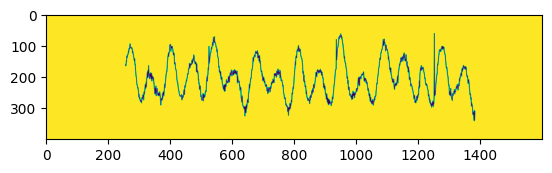

In [113]:
plt.imshow(Img_LC[778])
plt.show()

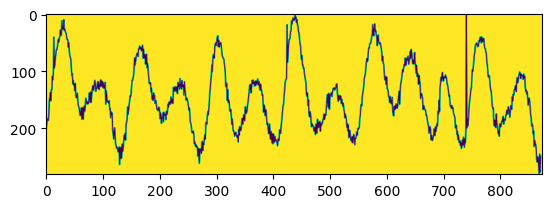

In [112]:
plt.imshow(Img_LC_R[778])
plt.show()

In [24]:


X_train, X_test, y_train, y_test = train_test_split(np.array(Img_LC), 
                                                    np.array(Clas_Stars["ClasBin"]),
                                                    test_size=0.3)

X_val,  X_test,  y_val,  y_test  = train_test_split(X_test, 
                                                    y_test,
                                                    test_size=0.333)

#X_train = X_train.reshape((len(X_train), 1285, 1))
#X_test  = X_test.reshape((len(X_test), 1285, 1))
#X_val   = X_val.reshape((len(X_val), 1285, 1))

print("Tamaño de entrenamiento:",X_train.shape,
      "\nTamaño de validacion:",X_val.shape,
      "\nTamaño de prueba:", X_test.shape,
      "\nDatos totales:",len(X_train)+len(X_val)+len(X_test))

MemoryError: Unable to allocate 36.6 GiB for an array with shape (7681, 400, 1600) and data type float64